# Exoplanets HW3 
## Steven Stetzler and Miles Currie

### Problem 1

Install Rebound

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rebound
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from matplotlib import rcParams
import sys

In [2]:
rcParams['figure.figsize'] = [12, 10]
rcParams['font.size'] = 18

### Problem 2
Look up the parameters of the planet system GJ 876.  Assume the planets’ orbits lie in a plane, and vary the inclination of the system.  At what inclination does the system become unstable after 1000 orbits of the inner planet? What upper limit does this place on the planets’ masses?  At what inclination would the planets be seen to transit?  What lower limit does this place on the planets’ masses?


### From [Rivera et al. (2010)](https://iopscience.iop.org/article/10.1088/0004-637X/719/1/890/pdf):
<img src="GJ876_planet_params.png">
<img src="GJ876_stellar_params.png">

In [55]:
class Planet():
    def __init__(self, P, m, a, K, e, omega, mean_anomoly):
        self.P = P 
        self.m = m
        self.a = a
        self.K = K
        self.e = e
        self.omega = omega
        self.mean_anomoly = mean_anomoly
        
    def copy(self):
        return Planet(self.P, self.m, self.a, self.K, self.e, self.omega, self.mean_anomoly)

In [56]:
sim = rebound.Simulation()
sim.units = ('days', 'AU', 'Mearth')
print("G = {0}.".format(sim.G))

G = 8.88769244513e-10.


In [53]:
def run_simulation(planets, integration_time, plot=False, num_steps=10, archive_interval=10, planetb_mass_scalar=1, **kwargs):    
    sim = rebound.Simulation()
    sim.units = ('days', 'AU', 'Mearth')

    # Add center star
    sim.add(m=0.32 * M_SUN_TO_M_EARTH)
    # Add all planets
    for planet in planets:
        sim.add(m=planet.m, a=planet.a, e=planet.e, M=planet.mean_anomoly, omega=planet.omega)
    
    planets[0].m *= planetb_mass_scalar # for mass variation in TTV problem 4
    
    # convert to center of mass coordinates
    sim.move_to_com()
    sim.dt = sim.particles[1].P * 0.05  # timestep is 5% of orbital period
    sim.integrator = "whfast"
    sim.automateSimulationArchive("archive.bin", interval=archive_interval, deletefile=True)

    sim.move_to_com()
    
    if plot:
        for i in range(num_steps):
            sim.integrate(sim.t + integration_time / num_steps)
            fig = rebound.OrbitPlot(sim, color=True, unitlabel="[AU]", lim=1.2 * max([planet.a for planet in planets]))
            display(fig)
            plt.close(fig)
            clear_output(wait=True)
        display(fig)
    else:
        sim.integrate(integration_time)
        
    return sim

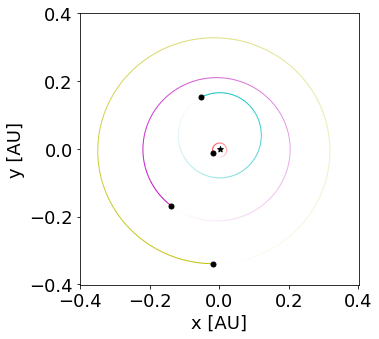

In [57]:
M_JUPITER_TO_M_EARTH = 317.8
M_SUN_TO_M_EARTH = 332946

planets = [
    Planet(1.937780, 6.83, 0.02080665, 6.56, 0.207, 234, 355),
    Planet(30.0881, M_JUPITER_TO_M_EARTH * 0.7142, 0.129590, 88.34, 0.25591, 48.76, 294.59),
    Planet(61.1166, M_JUPITER_TO_M_EARTH * 2.2756, 0.208317, 214, 0.0324, 50.3, 325.7),
    Planet(124.26, 14.6, 0.3343, 3.42, 0.055, 239, 335)
]

sim = run_simulation(planets, 50, plot=True)

In [7]:
def modify_masses(planets, inclination, ref_m_sinis, verbose=True, **kwargs):
    modified_masses = [ref_m_sini / np.sin(inclination) for ref_m_sini in ref_m_sinis]
    ret_planets = [planet.copy() for planet in planets]
    if verbose:
        print("Modified masses:")
    for ret_planet, modified_mass in zip(ret_planets, modified_masses):
        if verbose:
            print(f"  {ret_planet.m} --> {modified_mass}")
        ret_planet.m = modified_mass
    
    return ret_planets

SyntaxError: invalid syntax (<ipython-input-7-177a50c11c2b>, line 8)

In [8]:
def run_simluation_at_inclination(planets, inclination, integration_time, **kwargs):
    DEG_TO_RAD = np.pi / 180
    ref_inclination = 59 * DEG_TO_RAD
    
    ref_m_sinis = [planet.m * np.sin(ref_inclination) for planet in planets]
    sim_planets = modify_masses(planets, inclination, ref_m_sinis, **kwargs)
    
    return run_simulation(sim_planets, integration_time, **kwargs)

In [9]:
# Check if any of the orbits are within the Hill radius of one another
# Return True if orbits are unstable
# Return False if orbits are stable
def orbits_unstable(particles):
    positions = np.array([np.array([particle.x, particle.y, particle.z]) for particle in particles])
    distances = np.zeros((len(particles), len(particles)))
    
    def hill_spheres_intersect():
        r_H_list = [particle.a * (1-particle.e) * (particle.m / particles[0].m) for particle in particles[1:]]

        for i in range(len(particles)):
            for j in range(len(particles)):
                distances[i, j] = np.sqrt(np.sum((positions[i] - positions[j])**2))

        for i, (distance, r_H) in enumerate(zip(distances[1:], r_H_list)):
            distance_minus_r_H = distance - r_H
            negative_indices = np.where(distance_minus_r_H < 0)[0]
            negative_indices = [j for j in negative_indices if j != i + 1]
            if len(negative_indices) > 0:
                return True
            
        return False
    
    # Check if each planet's distance from the star is less than another planet's semi-major axis
    def orbits_cross():        
        semi_major_axes = [particle.a for particle in particles[1:]]
        
        semi_major_axes_sorted = np.sort(semi_major_axes)
        
        return not np.array_equal(semi_major_axes, semi_major_axes_sorted)
    
    return hill_spheres_intersect() or orbits_cross()

def simulation_unstable():
    sa = rebound.SimulationArchive("archive.bin")
    return np.any([orbits_unstable(sim.particles) for sim in sa])

In [10]:
inclinations = np.linspace(0.01, np.pi/2, 100)
stability_checks = []
for i, inclination in enumerate(inclinations):
    sim = run_simluation_at_inclination(planets, 
                                        inclination, 
                                        planets[0].P * 2000, 
                                        verbose=False,
                                        archive_interval=100)
    stability_checks.append(simulation_unstable())
    print(f"{100 * (i + 1) / len(inclinations)}% done   ", end="\r")
    sys.stdout.flush()

SyntaxError: invalid syntax (<ipython-input-10-e32ad5892224>, line 10)

In [11]:
plt.plot(inclinations * 180 / np.pi, stability_checks)
plt.xlabel(r"$i$ (deg)")
plt.yticks([0, 1], ["False", "True"])
plt.ylabel("Orbits Unstable")
plt.show()

NameError: name 'inclinations' is not defined

In [12]:
for sim in sa:
    print(orbits_unstable(sim.particles, planets))

NameError: name 'sa' is not defined

In [13]:
distances, r_H_list = analyze_orbits(sim.particles, planets)
# for r_H in r_H_list:
#     print((distances - r_H))

NameError: name 'analyze_orbits' is not defined

In [14]:
distances, distances[np.triu_indices(5, 1)]

NameError: name 'distances' is not defined

In [15]:
sim = run_simluation_at_inclination(planets, np.pi / 8, 1000, plot=True, num_steps=20) 

NameError: global name 'modify_masses' is not defined

In [16]:
sim.particles[1]

<rebound.Particle object, m=6.83 x=-0.01744531932 y=-0.0125890944347 z=0.0 vx=0.0262327021625 vy=-0.0549929298282 vz=0.0>

In [17]:
ref_m_sinis = [planet.m * np.sin(ref_inclination) for planet in planets]
sim_planets = modify_masses(planets, np.pi/16, ref_m_sinis)
print([planet.m for planet in sim_planets])
sim = run_simulation(sim_planets, 1, 10, plot=True)

NameError: name 'ref_inclination' is not defined

In [18]:
run_simluation_at_inclination(planets, np.pi / 2, 1, 10, plot=True)

TypeError: run_simluation_at_inclination() takes exactly 3 arguments (5 given)

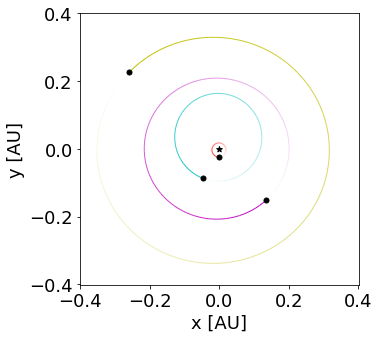

In [19]:
sim = run_simulation(planets, 1.937780, 3)
planet_positions = [[particle.x, particle.y, particle.z] for particle in sim.particles[1:]]

In [20]:
planet_positions

[[-0.0020091255536569016, -0.023904392589769875, 0.0],
 [-0.04610077148649902, -0.08715910005481509, 0.0],
 [0.13506114192756724, -0.15093980211572638, 0.0],
 [-0.25841836314766264, 0.2271953747869938, 0.0]]

### Problem 3
Compute the radial velocity of the star, and then fit this RV with four Keplerian orbits. How big are the residuals?  How does this compare to typical RV errors?

### Problem 4
Look at REBOUND TTV example.  Make a plot of the TTVs of GJ 876 c over 4 years (assuming edge-on, so that planet would transit).  Measure amplitude and period of the sinusoidal variation component.  How does it change if you vary the mass of GJ 876 b downward and upward by a factor of 2?

In [59]:
sim = rebound.Simulation()
planetb_mass_scalar = 1
# Add center star
sim.add(m=0.32 * M_SUN_TO_M_EARTH)
for planet in planets:
    sim.add(m=planet.m, a=planet.a, e=planet.e, M=planet.mean_anomoly, omega=planet.omega)
planets[0].m *= planetb_mass_scalar # for mass variation in TTV problem 4
sim.move_to_com()

In [ ]:
N = int(round(4 * 365.25 / planets[0].P, 0))  # number of planet b transits in four years
N = 174 # like in example
transittimes = np.zeros(N)
p = sim.particles
i = 0
while i<N:
    y_old = p[1].y - p[0].y  # (Thanks to David Martin for pointing out a bug in this line!)
    t_old = sim.t
    sim.integrate(sim.t+0.5) # check for transits every 0.5 time units. Note that 0.5 is shorter than one orbit
    t_new = sim.t
    if y_old*(p[1].y-p[0].y)<0. and p[1].x-p[0].x>0.:   # sign changed (y_old*y<0), planet in front of star (x>0)
        while t_new-t_old>1e-7:   # bisect until prec of 1e-5 reached
            if y_old*(p[1].y-p[0].y)<0.:
                t_new = sim.t
            else:
                t_old = sim.t
            sim.integrate( (t_new+t_old)/2.)
        transittimes[i] = sim.t
        i += 1
        sim.integrate(sim.t+0.05)       # integrate 0.05 to be past the transit

In [ ]:
# do a linear least squares fit to remove the linear trend in transit times
A = np.vstack([np.ones(N), range(N)]).T
c, m = np.linalg.lstsq(A, transittimes)[0]

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.set_xlim([0,N])
ax.set_xlabel("Transit number")
ax.set_ylabel("TTV [hours]")
plt.scatter(range(N), (transittimes - (m*np.array(range(N)) + c))*(24.*365./2./np.pi))